In [61]:
import sys
import os
import numpy as np

sys.path.append(os.path.abspath(os.path.join('..', '..', '..', '..', 'models')))

In [62]:
from utils import get_cuda_info

get_cuda_info()

PyTorch version: 2.5.1+cu118
**********
_CUDA version: 
CUDA version:
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Wed_Oct_30_01:18:48_Pacific_Daylight_Time_2024
Cuda compilation tools, release 12.6, V12.6.85
Build cuda_12.6.r12.6/compiler.35059454_0

**********
CUDNN version: 90100
Available GPU devices: 1
Device Name: NVIDIA GeForce RTX 4070 Ti SUPER


### Zdobycie danych

In [63]:
LANDMARK_INDEXES = np.array([x for x in range(478)])
REFERENCE_POINT_IDX = 0

In [64]:
from utils import load_data

all_data, all_labels = load_data('ravdess')

### Preprocessing

In [65]:
from utils import preprocess_data

X_train, X_val, X_test, y_train, y_val, y_test = preprocess_data(all_data, all_labels)

In [66]:
print(X_train.shape)
print(y_train.shape)

torch.Size([2012, 157, 478, 2])
torch.Size([2012, 8])


## MODEL

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [67]:
class EmotionClassifier(nn.Module):
    def __init__(self):
        super(EmotionClassifier, self).__init__()
        
        # Spatial feature extraction using Conv1D
        self.conv1 = nn.Conv1d(in_channels=2, out_channels=32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool1d(kernel_size=2)
        
        # LSTM layers for temporal feature extraction
        self.lstm1 = nn.LSTM(input_size=32 * 239, hidden_size=128, batch_first=True, bidirectional=True)
        self.lstm2 = nn.LSTM(input_size=128 * 2, hidden_size=64, batch_first=True)
        
        # Fully connected classification layer
        self.fc = nn.Linear(64, 8)  # 8 emotion classes

    def forward(self, x):
        # x shape: (batch_size, frames, landmarks, coordinates)
        batch_size, frames, landmarks, coordinates = x.shape
        
        # Reshape for Conv1D: (batch_size * frames, landmarks, coordinates)
        x = x.view(-1, landmarks, coordinates).permute(0, 2, 1)
        
        # Spatial feature extraction
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        
        # Flatten spatial features
        x = x.view(batch_size, frames, -1)  # (batch_size, frames, features)
        
        # Temporal feature extraction
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        
        # Classification
        x = self.fc(x[:, -1, :])  # Take the last timestep's output
        x = F.softmax(x, dim=1)
        return x

## Trening

In [68]:
from torch.optim import Adam

model = EmotionClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=1e-4)

In [69]:
from torch.utils.tensorboard import SummaryWriter

writer_path = os.path.join('runs', 'torch_lstm', 'feature_selection')
writer = SummaryWriter(writer_path)

In [70]:
from utils.model_functions import train_torch_model_multiclass

train_torch_model_multiclass(model, criterion, optimizer, X_train, y_train, X_val, y_val, writer=writer)


                                          EPOCH STATISTICS                                          
Epoch       : 1
----------------------------------------------------------------------------------------------------
                     TRAINING                                         VALIDATION                    
----------------------------------------------------------------------------------------------------
Loss        : 130.829022                                    Loss        : 29.039175
Accuracy    : 0.1297                                    Accuracy    : 0.1276
Precision   : 0.0379                                    Precision   : 0.0160
Recall      : 0.1189                                    Recall      : 0.1250
F1 Score    : 0.0415                                    F1 Score    : 0.0283


                                          EPOCH STATISTICS                                          
Epoch       : 2
--------------------------------------------------------------------

## SHAP wartości

In [71]:
import shap
from tqdm import tqdm

In [72]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch_size = 10
num_samples = all_data.shape[0]
shap_values_all = []

model.eval()
explainer = shap.DeepExplainer(model, X_train[:5].to(device))
"""
== Lundberg et al. (2017) – "A Unified Approach to Interpreting Model Predictions" ==

Experiment: Compared different reference set sizes and found that after 1-3 samples, the marginal gain in accuracy was minimal.
Key Finding: Using more reference samples does not significantly change the rankings of important features.
"""

model.train() # because of RNN backprop error
for i in tqdm(range(0, num_samples, batch_size), total=num_samples / batch_size):
    batch = X_train[i : i + batch_size].to(device)
    shap_values_batch = explainer.shap_values(batch, check_additivity=False)
    shap_values_all.append(shap_values_batch)

shap_values_all = np.concatenate(shap_values_all, axis=0)


  0%|          | 0/287.5 [00:00<?, ?it/s]

C:\Users\Bartosz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\shap\explainers\_deep\deep_pytorch.py:243: UserWarning:

unrecognized nn.Module: LSTM

288it [03:30,  1.37it/s]                           


In [73]:
shap_values_all.shape

(2012, 157, 478, 2, 8)

In [74]:
shap_landmark_importance_per_frame = torch.tensor(shap_values_all).abs().sum(dim=3)
shap_landmark_importance_per_emotion = shap_landmark_importance_per_frame.abs().sum(dim=1)
shap_landmark_importance_avg = shap_landmark_importance_per_emotion.abs().mean(dim=-1).mean(dim=0)

In [75]:
shap_landmark_importance_avg.shape

torch.Size([478])

## Visualize best landmarks

In [76]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Top 100 landmarks: [287, 335, 410, 436, 308, 375, 415, 432, 304, 291, 292, 409, 416, 268, 273, 271, 434, 400, 411, 310, 306, 307, 365, 376, 385, 346, 372, 355, 294, 433, 262, 321, 451, 407, 322, 285, 435, 250, 325, 328, 373, 303, 379, 347, 356, 270, 61, 408, 95, 269, 331, 313, 391, 266, 336, 65, 85, 427, 333, 175, 146, 396, 81, 383, 253, 361, 295, 371, 57, 302, 337, 96, 251, 43, 129, 369, 324, 278, 183, 66, 288, 32, 73, 477, 7, 289, 403, 267, 88, 327, 77, 293, 424, 18, 334, 413, 225, 317, 105, 37]
Saving to top_100_important_landmarks_emotions.npy...


C:\Users\Bartosz\AppData\Local\Temp\ipykernel_680\1079701710.py:17: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




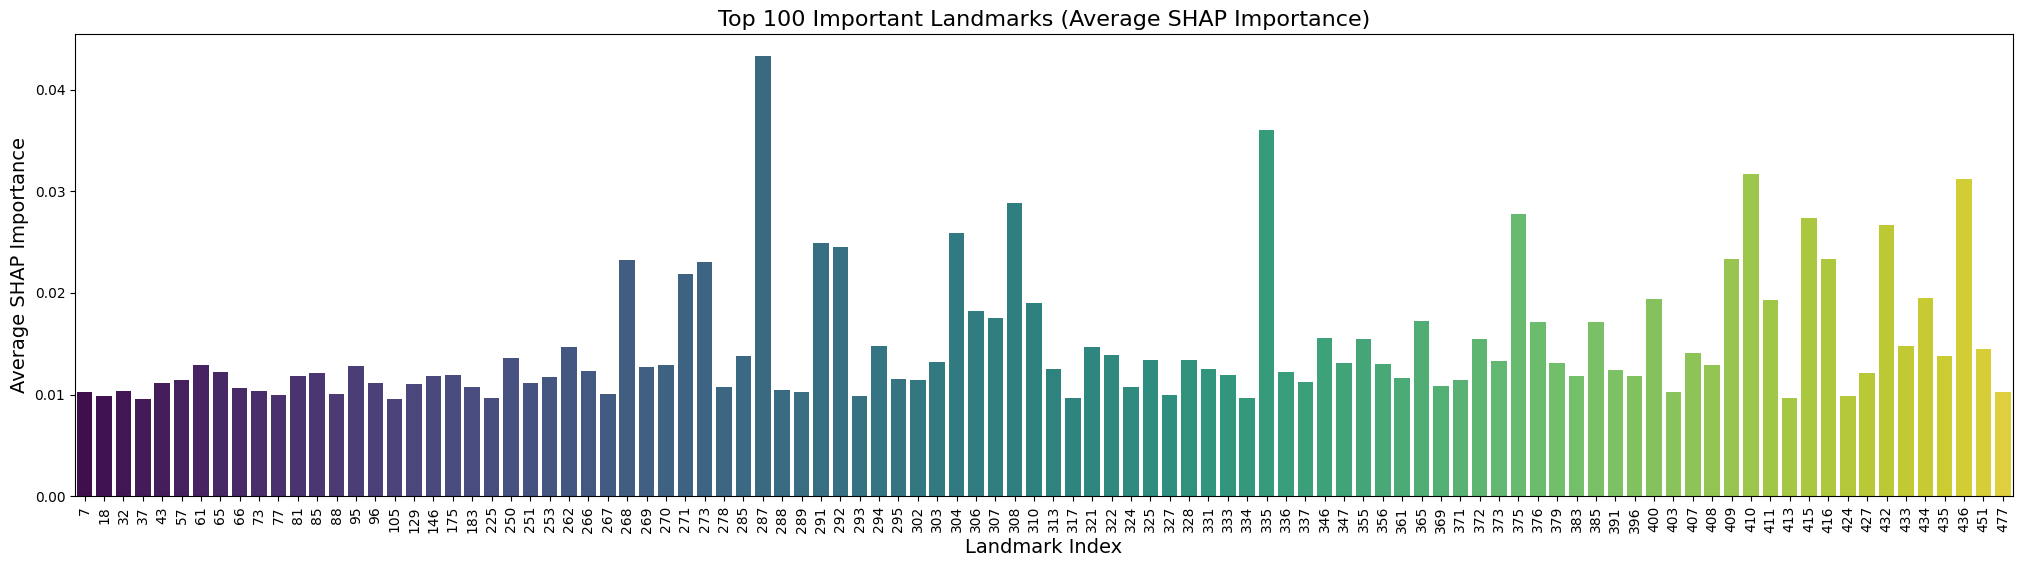

In [77]:
sorted_indices = torch.argsort(-shap_landmark_importance_avg)

sorted_importance = shap_landmark_importance_avg[sorted_indices]
sorted_landmarks = sorted_indices.tolist()

top_k = 100  # Number of top landmarks to show
df = pd.DataFrame({
    'Landmark Index': sorted_landmarks[:top_k],
    'Average SHAP Importance': sorted_importance[:top_k].numpy()
})
print(f"Top {top_k} landmarks: {sorted_landmarks[:top_k]}")
DATA_FILE = f'top_{top_k}_important_landmarks_emotions.npy'
print(f"Saving to {DATA_FILE}...")
np.save(DATA_FILE, np.array(sorted_landmarks[:top_k]))

plt.figure(figsize=(25, 6))
sns.barplot(x='Landmark Index', y='Average SHAP Importance', data=df, palette='viridis')
plt.title(f'Top {top_k} Important Landmarks (Average SHAP Importance)', fontsize=16)
plt.xlabel('Landmark Index', fontsize=14)
plt.ylabel('Average SHAP Importance', fontsize=14)
plt.xticks(rotation=90)
plt.show()

### Wizualizacja przy wykorzystaniu punktów referencyjnych:

In [78]:
reference_landmarks = np.load(os.path.join('..', '..', '..', '..', 'data', 'reference_points', 'key_points_xyz.npy'))[0, :, :2]
number_landmarks = reference_landmarks.shape[0]

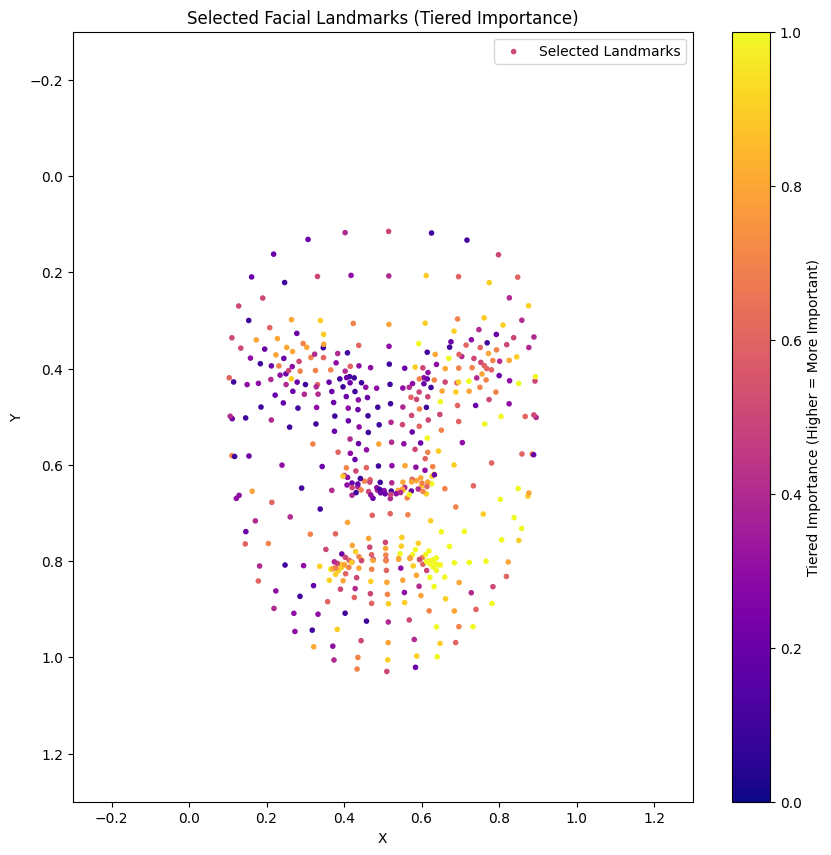

In [80]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

n_tiers = 10

# Rank-based importance: segment landmarks into `n_tiers` groups
sorted_indices = np.argsort(shap_landmark_importance_avg)
tiered_importance = np.zeros_like(shap_landmark_importance_avg)

for i in range(n_tiers):
    start = int(i * len(sorted_indices) / n_tiers)
    end = int((i + 1) * len(sorted_indices) / n_tiers)
    tiered_importance[sorted_indices[start:end]] = (i + 1) / n_tiers

# Plotting
cmap = plt.get_cmap('plasma')

plt.figure(figsize=(10, 10))
scatter = plt.scatter(
    reference_landmarks[:, 0],
    reference_landmarks[:, 1],
    c=tiered_importance,
    cmap=cmap,
    marker='.',
    label='Selected Landmarks',
    norm=Normalize(vmin=0, vmax=1)
)

plt.gca().invert_yaxis()
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Selected Facial Landmarks (Tiered Importance)")
plt.legend()

AXIS_OFFSET = 0.3
plt.xlim(0 - AXIS_OFFSET, 1 + AXIS_OFFSET)
plt.ylim(1 + AXIS_OFFSET, 0 - AXIS_OFFSET)

cbar = plt.colorbar(scatter)
cbar.set_label('Tiered Importance (Higher = More Important)')

plt.show()


### Średnia w odniesieniu do emocji

In [82]:
shap_landmark_importance_per_emotion.shape

torch.Size([2012, 478, 8])

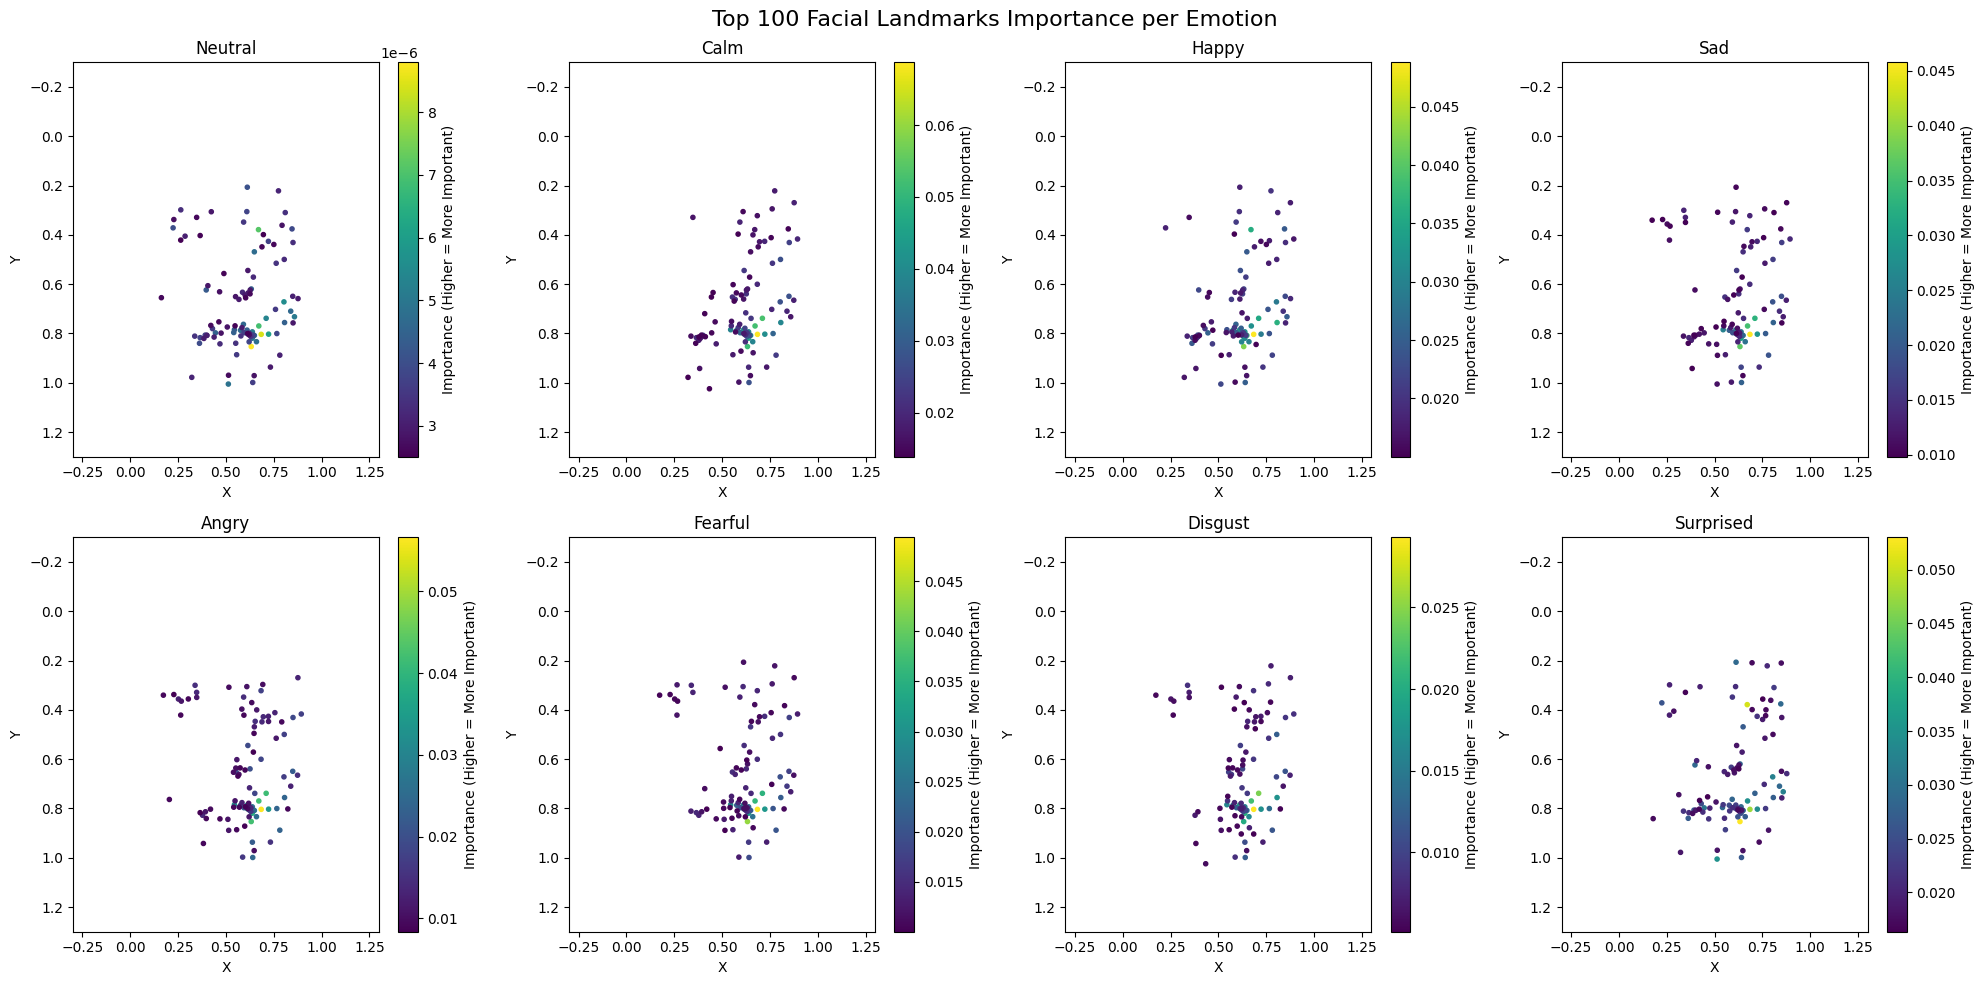

In [83]:
TOP_N_LANDMARKS_PER_EMOTION = 100

# Emotion labels
emotion_labels = ["Neutral", "Calm", "Happy", "Sad", "Angry", "Fearful", "Disgust", "Surprised"]

# Create a figure with 8 subplots (4 columns, 2 rows)
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle(f"Top {TOP_N_LANDMARKS_PER_EMOTION} Facial Landmarks Importance per Emotion", fontsize=16)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot for each emotion
for i, emotion in enumerate(emotion_labels):
    # Aggregate importance values for the current emotion (mean across the first dimension)
    importance_avg = torch.mean(shap_landmark_importance_per_emotion[:, :, i], dim=0)  # Shape: (478,)
    
    # Get the indices of the top N most important landmarks
    top_indices = torch.topk(importance_avg, TOP_N_LANDMARKS_PER_EMOTION).indices  # Shape: (TOP_N_LANDMARKS_PER_EMOTION,)
    
    # Get the coordinates and importance values for the top N landmarks
    top_landmarks = reference_landmarks[top_indices]  # Shape: (TOP_N_LANDMARKS_PER_EMOTION, 2)
    top_importance = importance_avg[top_indices]  # Shape: (TOP_N_LANDMARKS_PER_EMOTION,)
    
    # Create scatter plot for the top N landmarks
    scatter = axes[i].scatter(
        top_landmarks[:, 0],  # Convert to NumPy for plotting
        top_landmarks[:, 1],  # Convert to NumPy for plotting
        c=top_importance.numpy(),     # Convert to NumPy for plotting
        cmap='viridis',
        marker='.',
        label=f'Top {TOP_N_LANDMARKS_PER_EMOTION} Landmarks'
    )
    
    # Invert y-axis (common for image coordinates)
    axes[i].invert_yaxis()
    
    # Set titles and labels
    axes[i].set_title(emotion)
    axes[i].set_xlabel("X")
    axes[i].set_ylabel("Y")
    
    # Set axis limits with offset
    AXIS_OFFSET = 0.3
    axes[i].set_xlim(0 - AXIS_OFFSET, 1 + AXIS_OFFSET)
    axes[i].set_ylim(1 + AXIS_OFFSET, 0 - AXIS_OFFSET)
    
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=axes[i])
    cbar.set_label('Importance (Higher = More Important)')

# Adjust layout
plt.tight_layout()
plt.show()

### Interaktywna selekcja 

In [84]:
import plotly.graph_objects as go

fig = go.Figure()

frames = []
for t in range(1, number_landmarks):
    landmarks_plot = go.Scatter(
        x=[p[0] for p in reference_landmarks[[sorted_landmarks[:t]]][0]],
        y=[1 - p[1] for p in reference_landmarks[[sorted_landmarks[:t]]][0]],
        mode='markers',
        marker=dict(
            size=10,
            color='red',
            opacity=1
        )
    )

    frames.append(go.Frame(
        data=[landmarks_plot],
        name=str(t)
    ))

fig.frames = frames

fig.add_trace(go.Scatter(
    x=[p[0] for p in reference_landmarks[:1]],
    y=[1 - p[1] for p in reference_landmarks[:1]],
    mode='markers',
    marker=dict(
        size=10,
        color='red',
        opacity=1
    )
))

AXIS_OFFSET = 0.30
fig.update_layout(
    height=800,
    width=800,
    title="Most Important Landmarks",
    xaxis=dict(range=[0 - AXIS_OFFSET, 1 + AXIS_OFFSET], title="X coord"),
    yaxis=dict(range=[0 - AXIS_OFFSET, 1 + AXIS_OFFSET], title="Y coord"),
    sliders=[{
        "active": 0,
        "yanchor": "top",
        "xanchor": "left",
        "currentvalue": {
            "font": {"size": 20},
            "prefix": "no. landmarks: ",
            "visible": True,
            "xanchor": "right"
        },
        "transition": {"duration": 300, "easing": "cubic-in-out"},
        "pad": {"b": 10, "t": 50},
        "len": 0.9,
        "x": 0.1,
        "y": 0,
        "steps": [{
            "args": [
                [f.name],
                {
                    "frame": {"duration": 300, "redraw": True},
                    "mode": "immediate",
                    "transition": {"duration": 300}
                }
            ],
            "label": f.name,
            "method": "animate"
        } for f in frames]
    }]
)

fig.show()